<h1><center>CSCI - 4146 & 6409 - The Process of Data Science - Summer 2022</h1></center>
<h1><center>Assignment 3</h1></center>

<b>Meghna Kumar</b>  
B00892970 

<b>Vatsal Yadav</b>  
B00893030  

In [ ]:
import pandas as pd
import numpy as np

#to ignore waenings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#to plot graphs and maps
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import learning_curve

# Random Forest Algorithm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor

from mlxtend.evaluate import paired_ttest_resampled

# Evaluation Metrics
from sklearn.metrics import classification_report,confusion_matrix

###1.  Data understanding

Reading Amazon Book Review 1 Million Sample <a href='https://www.kaggle.com/datasets/parvezmrobin/amazon-book-review-1m-sample'>[1]</a> data 

In [ ]:
df = pd.read_json('./sample.jsonl', lines=True)
print(df.head(5))
df = df.convert_dtypes()

   overall vote  verified   reviewTime      reviewerID        asin  \
0        3    2     False  05 18, 2002   AJ8AQG2X9JJ2Y  0001712799   
1        5  NaN      True  12 11, 2014  A12Q7B7NT716RV  0001712799   
2        4    3     False   01 6, 2006  A1DK5AZMXS1QA3  0002006448   
3        4  NaN     False   12 8, 2014  A1JMSX54DO3LOP  0002005263   
4        2    2      True   03 3, 2014  A2IP27AZB3D1SM  0002005263   

                                      style     reviewerName  \
0  {'Format:': ' School & Library Binding'}   Donald Gillies   
1                 {'Format:': ' Hardcover'}  True Value Girl   
2                 {'Format:': ' Hardcover'}       Newton Ooi   
3            {'Format:': ' Kindle Edition'}        Bookzilla   
4            {'Format:': ' Kindle Edition'}   J. A. Drummond   

                                          reviewText  \
0  Dr. Seuss has some really brilliant books.  Th...   
1                                            Love it   
2  Hand-woven carpets are 

In [ ]:
df.info

<bound method DataFrame.info of         overall  vote  verified   reviewTime      reviewerID        asin  \
0             3     2     False  05 18, 2002   AJ8AQG2X9JJ2Y  0001712799   
1             5  <NA>      True  12 11, 2014  A12Q7B7NT716RV  0001712799   
2             4     3     False   01 6, 2006  A1DK5AZMXS1QA3  0002006448   
3             4  <NA>     False   12 8, 2014  A1JMSX54DO3LOP  0002005263   
4             2     2      True   03 3, 2014  A2IP27AZB3D1SM  0002005263   
...         ...   ...       ...          ...             ...         ...   
999995        3  <NA>      True   12 1, 2017  A1PLIAXAWGGEZO  B01HH2OZVS   
999996        3  <NA>     False  12 22, 2016  A1Q3MLS48AUBKO  B01HHC2MD6   
999997        5  <NA>     False   07 2, 2016  A34MRZFAZPPESL  B01HHC2MD6   
999998        5  <NA>      True  01 26, 2017    ARFHS6IU8WI0  B01HIIHU7W   
999999        5  <NA>      True   07 4, 2016  A22FAHV2R6BUVR  B01HJBPTUI   

                                           style  \
0  

Calculating the length, word count and isalnum for reviewText, summary, and reviewerName for better understanding of data

In [ ]:
df['reviewTextLength']  = df['reviewText'].str.len()

In [ ]:
df['reviewerNameLength']  = df['reviewerName'].str.len()
df['summaryLength']  = df['summary'].str.len()

In [ ]:
summaryWord = df['summary'].map(lambda each: len(str(each).split()))

In [ ]:
df['summaryWord'] = pd.DataFrame(summaryWord)

In [ ]:
reviewTextWord = df['reviewText'].map(lambda each: len(str(each).split()))
df['reviewTextWord'] = pd.DataFrame(reviewTextWord)

In [ ]:
reviewerNameWord = df['reviewerName'].map(lambda each: len(str(each).split()))
df['reviewerNameWord'] = pd.DataFrame(reviewerNameWord)

In [ ]:
reviewerNameIsAlNum = df['reviewerName'].map(lambda each: (str(each).isalnum()))
df['reviewerNameIsAlNum'] = pd.DataFrame(reviewerNameIsAlNum)

In [ ]:
reviewTextIsAlNum = df['reviewText'].map(lambda each: (str(each).isalnum()))
df['reviewTextIsAlNum'] = pd.DataFrame(reviewTextIsAlNum)

In [ ]:
summaryIsAlNum = df['summary'].map(lambda each: (str(each).isalnum()))
df['summaryIsAlNum'] = pd.DataFrame(summaryIsAlNum)

Converting the the categorical features to continuous feature

In [ ]:
df = pd.get_dummies(df, columns=['reviewerNameIsAlNum','reviewTextIsAlNum','summaryIsAlNum','verified'])

**1. Build the data quality report.**

In [ ]:
#Code Reference: This code has been taken from CSCI 6709 Process of Data Science Tutorial 2 [2]
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

In [ ]:
build_continuous_features_report(df)

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
overall,1000000,0.0000,5,1.0,4,4.373181e+00,5.000000e+00,5,5.000000e+00,9.996799e-01
unixReviewTime,1000000,0.0000,7514,849657600.0,1.37627e+09,1.406255e+09,1.425686e+09,1.4726e+09,1.537920e+09,1.010109e+08
reviewTextLength,1000000,0.0124,7916,1.0,114,5.411127e+02,2.270000e+02,599,3.175900e+04,8.680130e+02
reviewerNameLength,1000000,0.0034,125,1.0,7,1.112015e+01,1.100000e+01,15,3.260000e+02,5.576594e+00
summaryLength,1000000,0.0307,261,1.0,10,2.583527e+01,1.900000e+01,34,5.570000e+02,1.996028e+01
summaryWord,1000000,0.0000,70,0.0,2,4.613507e+00,3.000000e+00,6,1.120000e+02,3.679922e+00
reviewTextWord,1000000,0.0000,2000,0.0,21,9.648489e+01,4.200000e+01,108,5.359000e+03,1.506114e+02
reviewerNameWord,1000000,0.0000,26,0.0,1,1.832561e+00,2.000000e+00,2,2.700000e+01,8.510017e-01
reviewerNameIsAlNum_False,1000000,0.0000,2,0.0,0,6.544260e-01,1.000000e+00,1,1.000000e+00,4.755553e-01
reviewerNameIsAlNum_True,1000000,0.0000,2,0.0,0,3.455740e-01,0.000000e+00,1,1.000000e+00,4.755553e-01


> Observations

* reviewTextLength, reviewerNameLength and summaryLength have a missing percentage of 0.0124, 0.0034 and 0.0307 respectively.
* After all the cotegorical converted continuous features, it is overall that has less cardinality.
* reviewTextLength has the highest cardinality - 7916

In [ ]:
#Code Reference: This code has been taken from CSCI 6709 Process of Data Science Tutorial 2 [2]
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list()).T

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list()).T

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

Extracting Format from the style column and dropping style then because it is in json format

In [ ]:
df['format'] = df['style'].map(lambda x: x['Format:'] if x is not None and type(x) is not float and 'Format:' in x.keys() else None)

In [ ]:
df = df.drop(['style'], axis=1) 

Dropping image column because it will not serve any purpose later in the dataset.

In [ ]:
df = df.drop(['image'], axis=1)

In [ ]:
build_categorical_features_report(df)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
vote,1000000,80.4511,473,2,61834,6.1834,3,32697,3.2697
reviewTime,1000000,0.0000,7514,"02 20, 2015",1537,0.1537,"03 29, 2016",1243,0.1243
reviewerID,1000000,0.0000,610262,A2F6N60Z96CAJI,317,0.0317,A2OJW07GQRNJUT,240,0.0240
asin,1000000,0.0000,323635,038568231X,1013,0.1013,0297859382,828,0.0828
reviewerName,1000000,0.0034,435945,Amazon Customer,46661,4.6661,Kindle Customer,32034,3.2034
reviewText,1000000,0.0124,952186,Great,1105,0.1105,good,1071,0.1071
summary,1000000,0.0307,629717,Five Stars,93655,9.3655,Four Stars,23557,2.3557
format,1000000,1.7879,89,Kindle Edition,561493,56.1493,Paperback,229310,22.9310


> Observation

* 'vote' column has highest missing percentage count i.e 80.45
* Other columns having some missing percentage are reviewerName, reviewText, summary and format
* Mode of reviewerName is 'Amazon Customer' which means most of the users are anonymous and have not entered their actual name
* 'Kindle Edition' has the highest number of frequency in format.

Feature visualization - Continuous Features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f29139cbe50>,
      dtype=object)

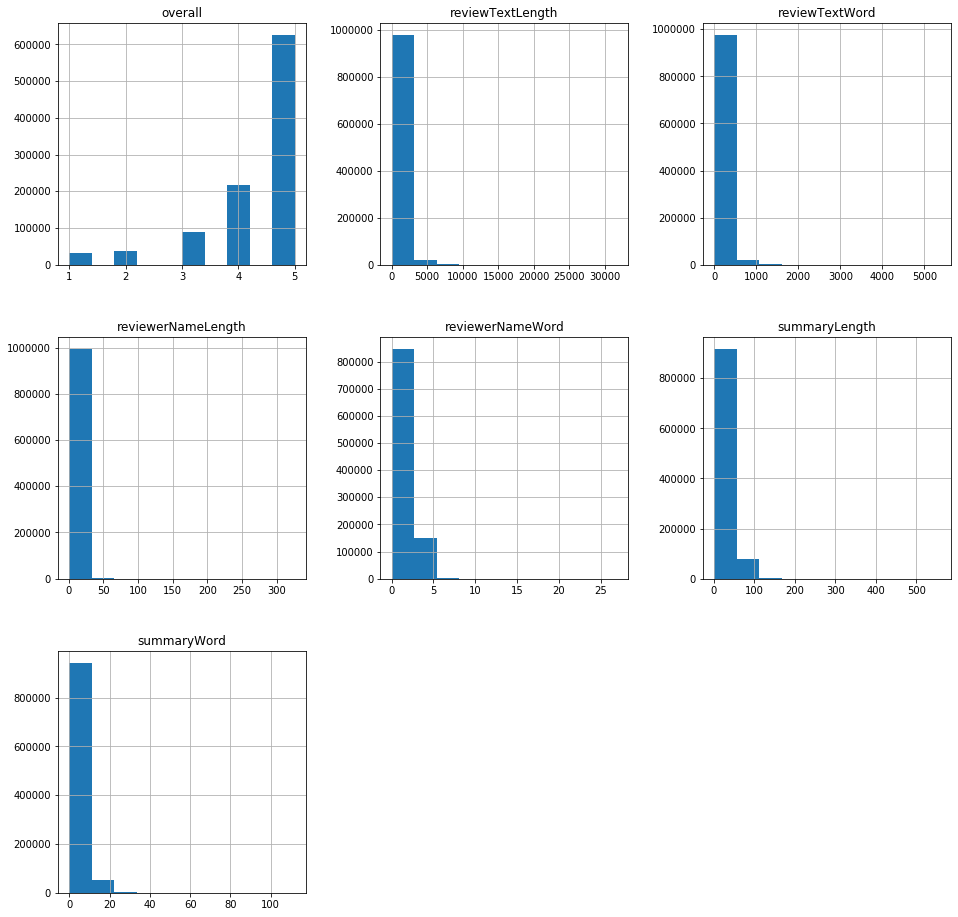

In [ ]:
df.hist(column=(['overall','reviewTextLength','reviewerNameLength','summaryLength','summaryWord','reviewTextWord','reviewerNameWord']),figsize=(16,16))

> Observation

* All the values of reviewerNameLength are under 50
* Maximum count of summaryWord is between 0 and 10
* overall score 5 has the highest count
* reviewTextLength is between 0 and 4000 for most of the values.

Feature Visualisation - Categorical Features

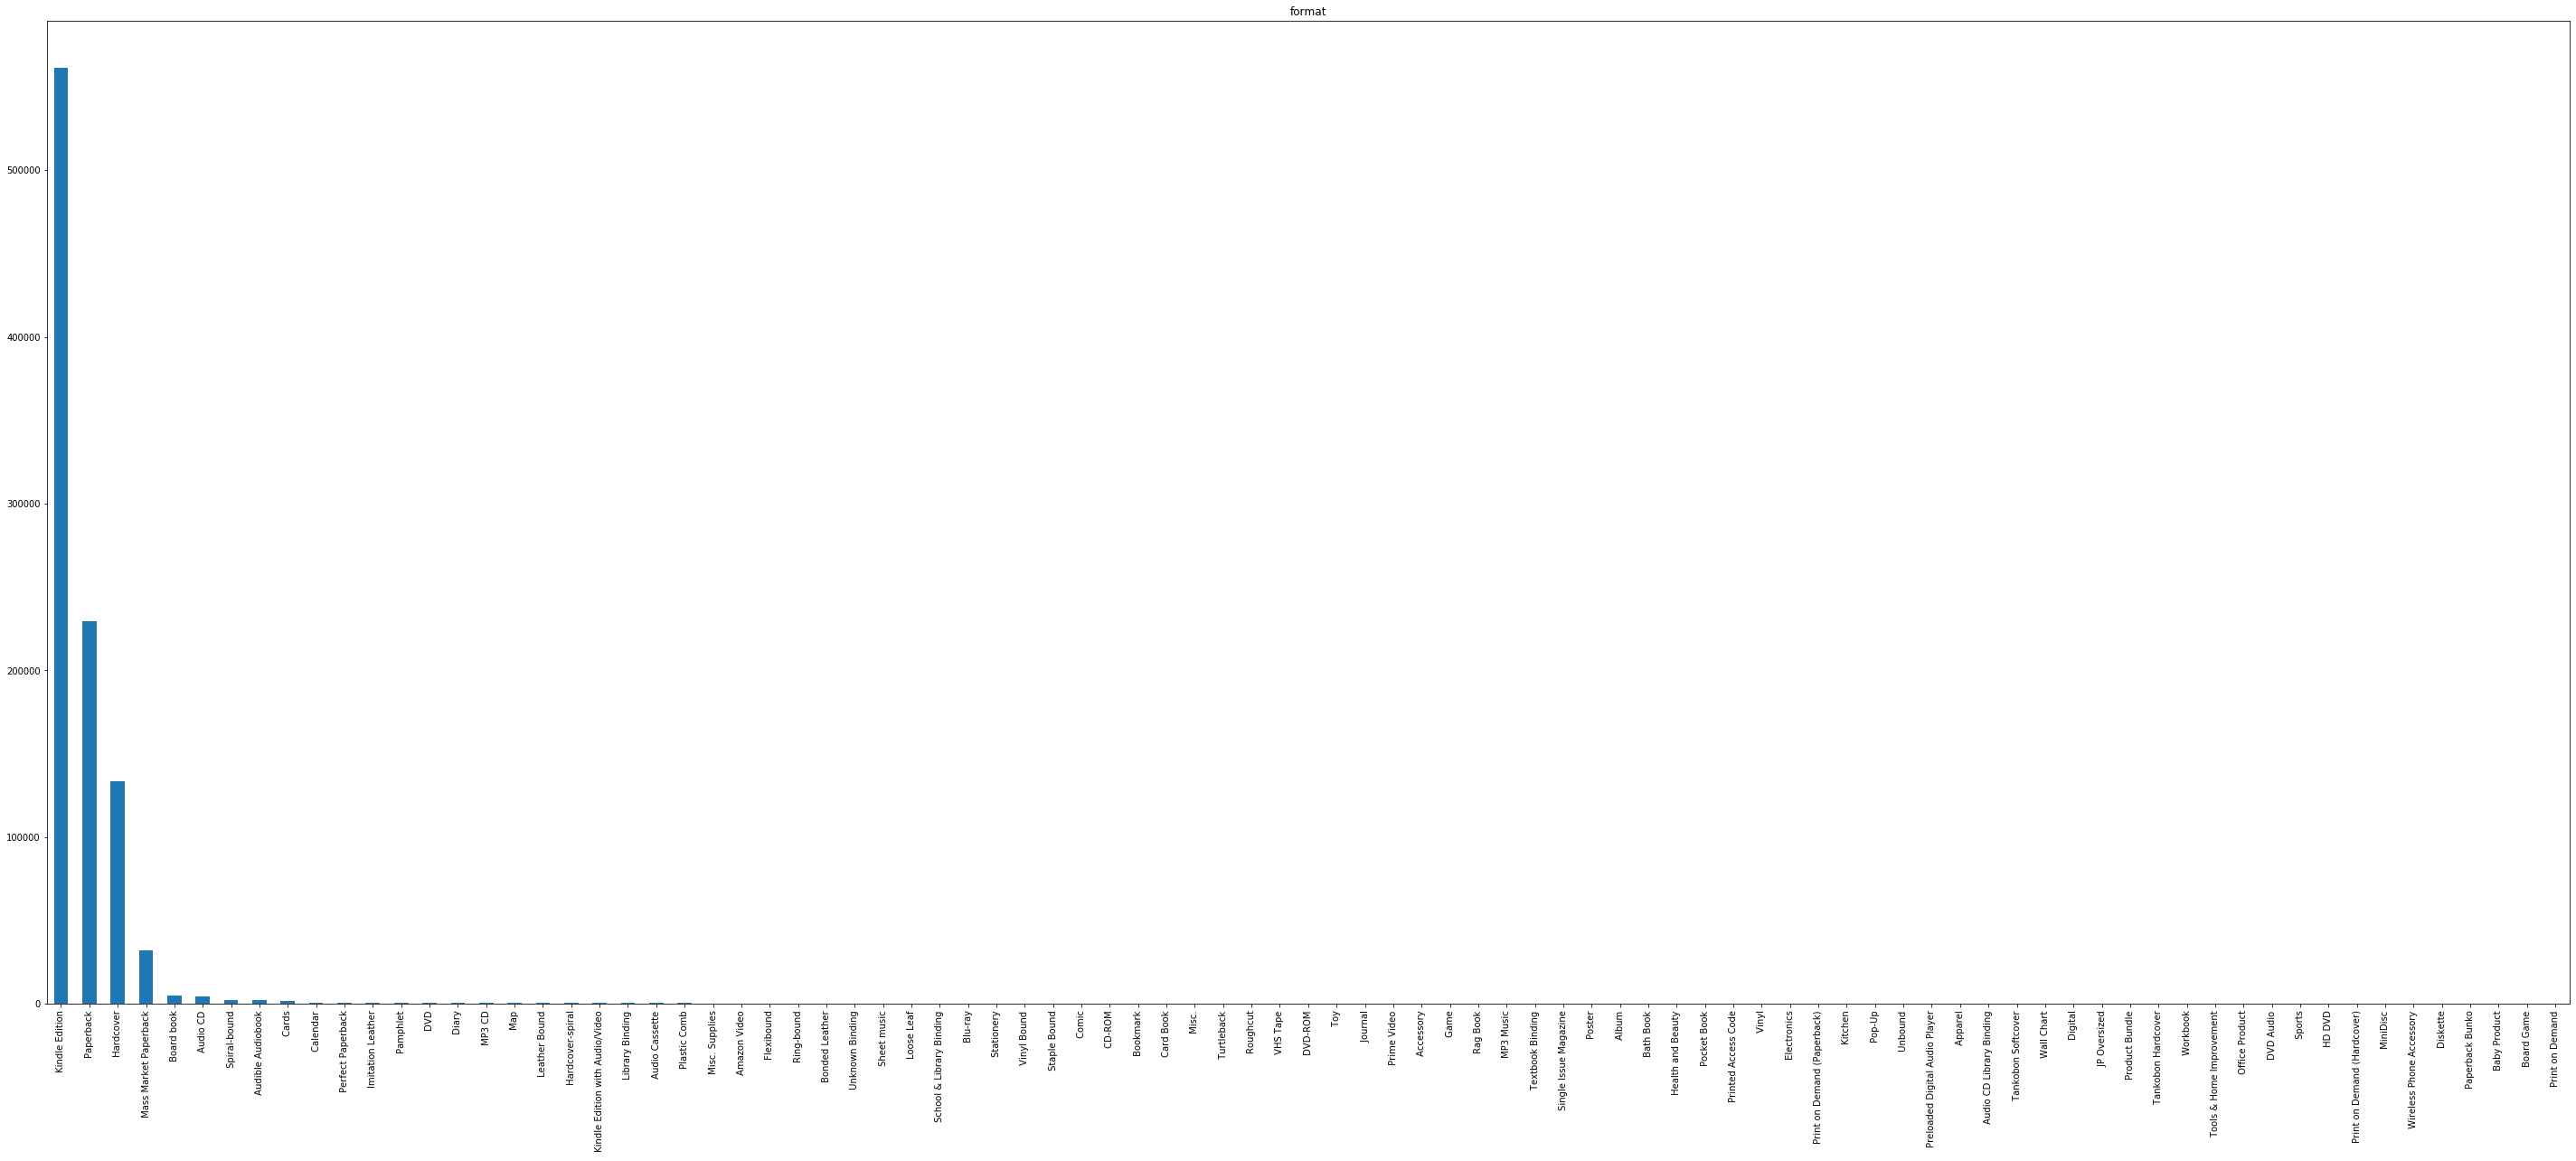

In [ ]:
df['format'].value_counts().plot.bar(figsize=(50,20)).set_title('format');

> Observations


*   Kindle Edition has the highest count, paperback, hardcover and mass market paperback coming after it.
*   Board book, Audio CD, SPiral bound, Audible Audiobook, Cards are very low.
* All others are almost close to negligible



**2. Identify data quality issues and build data quality plan**

The most common data quality issues are:

*   Missing values
*   Irregular cardinality
*   Outliers

Missing Values:

From the continuous and categorical features above we see that even though the count of all the columns is 100000, following columns have a missing percentage:

- Continuous feature: reviewTextLength, reviewerNameLength, summaryLength

- Categorical features: vote, reviewerName, reviewText and summary


Checking again if there are null values in data frame using isnull

In [ ]:
print("Boolean mask of missing values:\n",df.isnull())

Boolean mask of missing values:
         overall   vote  reviewTime  reviewerID   asin  reviewerName  \
0         False  False       False       False  False         False   
1         False   True       False       False  False         False   
2         False  False       False       False  False         False   
3         False   True       False       False  False         False   
4         False  False       False       False  False         False   
...         ...    ...         ...         ...    ...           ...   
999995    False   True       False       False  False         False   
999996    False   True       False       False  False         False   
999997    False   True       False       False  False         False   
999998    False   True       False       False  False         False   
999999    False   True       False       False  False         False   

        reviewText  summary  unixReviewTime  reviewTextLength  ...  \
0            False    False           False 

>Observations 

- From the above result it can be observed that 'vote' definitely has a lot of null values, for others it isn't visible because the dataset is too large. 

- From the continuous and categorical features report above it is observed that the missing percentage for vote is 80.451 while for others it is less than 0.05%.

- Hence, before dropping the null values removing the vote column as it will affect the consistency in dataset if null values are removed with it.

Irregular cardinality:

General Issues with irregular cardinality are:

- Features with a cardinality of 1

- Too low cardinality continuous features

- Too high cardinality categorical features

With the above findings for categorical and continuous features, it is observed that -

- There are no columns with cardinality 1
- Continuous features 'overall' have low cardinalities of 5 but, it can't be removed as overall will be our target variable later.
- Most of the categorical features have a very high cardinality but we won't be dropping them as the data later requires modeling to be done on textual data hence we need to keep it. 

Outliers

- The values which lie completely secluded from all other values are outliers.
- Since it is a review data(textual format) we can expect a lot of outliers hence not removing them

**3. Pre-processing data according to data quality plan**

Dropping the 'vote' column

In [ ]:
df=df.drop(['vote'], axis=1)

Dropping all the null values

In [ ]:
df.dropna(inplace=True)

In [ ]:
# Drop null values in columns
df.dropna(axis='columns')

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewTextLength,reviewerNameLength,...,reviewerNameWord,reviewerNameIsAlNum_False,reviewerNameIsAlNum_True,reviewTextIsAlNum_False,reviewTextIsAlNum_True,summaryIsAlNum_False,summaryIsAlNum_True,verified_False,verified_True,format
0,3,"05 18, 2002",AJ8AQG2X9JJ2Y,0001712799,Donald Gillies,Dr. Seuss has some really brilliant books. Th...,A below-average Dr. Seuss Book,1021680000,617,14,...,2,1,0,1,0,1,0,1,0,School & Library Binding
1,5,"12 11, 2014",A12Q7B7NT716RV,0001712799,True Value Girl,Love it,Five Stars,1418256000,7,15,...,3,1,0,1,0,1,0,0,1,Hardcover
2,4,"01 6, 2006",A1DK5AZMXS1QA3,0002006448,Newton Ooi,Hand-woven carpets are one of the few products...,Tourism as history,1136505600,1419,10,...,2,1,0,1,0,1,0,1,0,Hardcover
3,4,"12 8, 2014",A1JMSX54DO3LOP,0002005263,Bookzilla,"Compelling, twisting mystery involving several...","Compelling, twisting mystery",1417996800,314,9,...,1,0,1,1,0,1,0,1,0,Kindle Edition
4,2,"03 3, 2014",A2IP27AZB3D1SM,0002005263,J. A. Drummond,I have read many of the Hillerman books and en...,Tony missed the mark,1393804800,235,14,...,3,1,0,1,0,1,0,0,1,Kindle Edition
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,3,"12 1, 2017",A1PLIAXAWGGEZO,B01HH2OZVS,Linda Cope,What I liked most was the personal stories of ...,What I liked most was the personal stories of ...,1512086400,364,11,...,2,1,0,1,0,1,0,0,1,Kindle Edition
999996,3,"12 22, 2016",A1Q3MLS48AUBKO,B01HHC2MD6,weaselbit,The story is alright. The writing style is a b...,The story is alright. The writing style is a ...,1482364800,130,9,...,1,0,1,1,0,1,0,1,0,Kindle Edition
999997,5,"07 2, 2016",A34MRZFAZPPESL,B01HHC2MD6,skygypsy,l really loved this little book. The author's...,A Lovely Little Feel-Good Story,1467417600,200,8,...,1,0,1,1,0,1,0,1,0,Kindle Edition
999998,5,"01 26, 2017",ARFHS6IU8WI0,B01HIIHU7W,DonnaL,I have read everything Keith Blackmore has wri...,Love Keith Blackmore's books!,1485388800,120,6,...,1,0,1,1,0,1,0,0,1,Kindle Edition


**4. Answer the following questions:**

**1. What is the distribution of the top 50 most frequent words (excluding the
stop words) for each of the textual features?**

Removing stop words for textual features

In [ ]:
df_obs = df

In [ ]:
# Code Reference: https://stackoverflow.com/a/43407993/12146592 [3]
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS

In [ ]:
df_obs['reviewTextWithoutStopwords'] = df_obs['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_obs['summaryWithoutStopwords'] = df_obs['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_obs['reviewerNameWithoutStopwords'] = df_obs['reviewerName'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_obs['formatWithoutStopwords'] = df_obs['format'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [ ]:
# Code Reference: https://www.kaggle.com/code/thrillanalysis/amazon-reviews-analysis/notebook [4]
from nltk import FreqDist
def freq_words(x, terms = 50):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 50 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(50,20))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

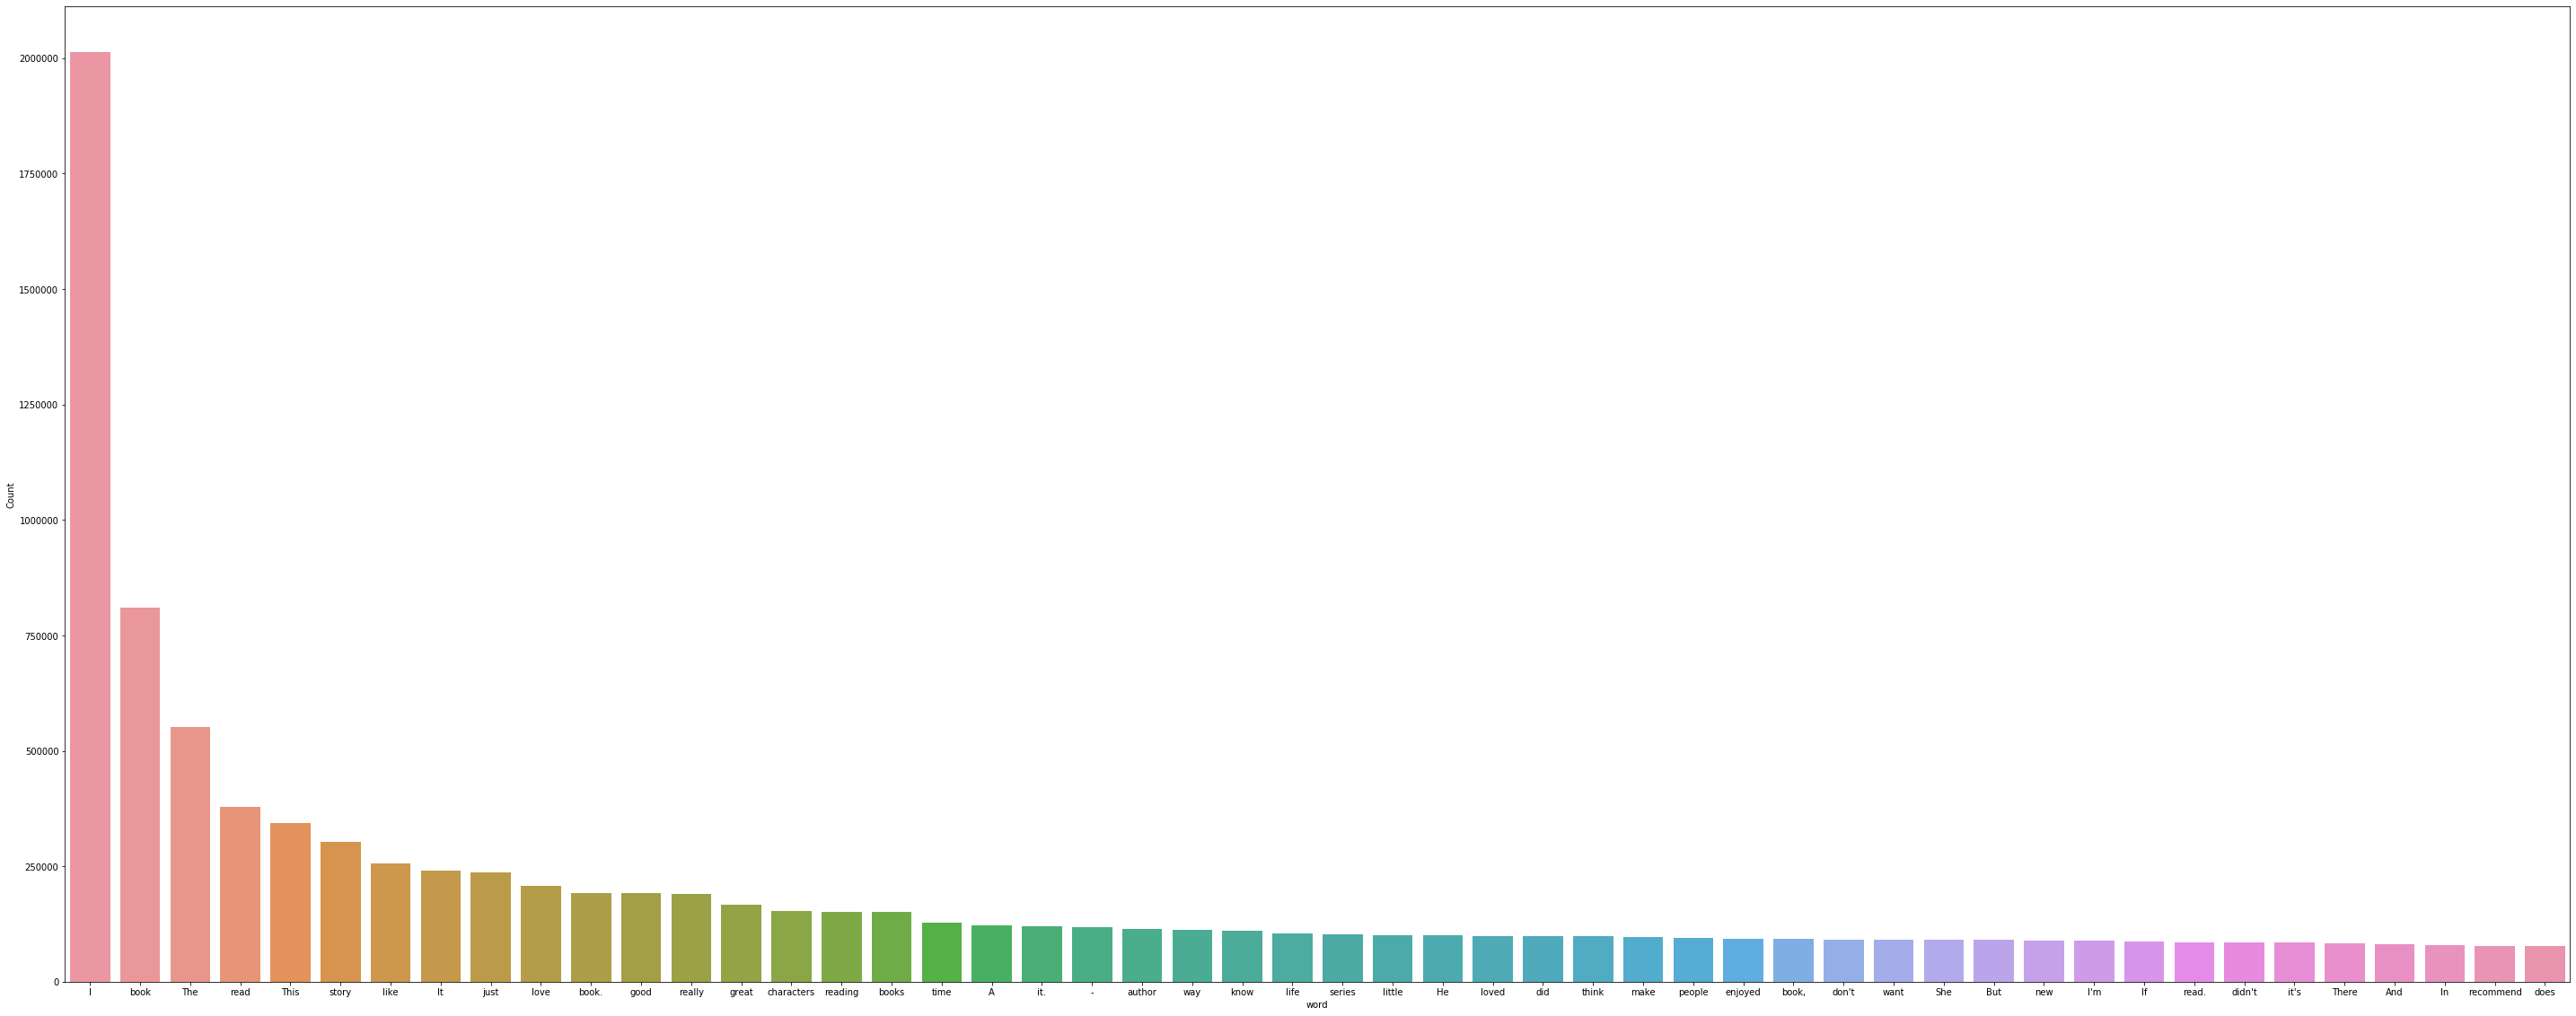

In [ ]:
freq_words(df_obs['reviewTextWithoutStopwords'])

In [ ]:
from collections import Counter

In [ ]:
# Code Reference: https://stackoverflow.com/a/29903102/12146592 [5]
Counter(" ".join(df_obs['reviewTextWithoutStopwords']).split()).most_common(50)

[('I', 2012500),
 ('book', 810441),
 ('The', 551988),
 ('read', 378412),
 ('This', 344269),
 ('story', 302931),
 ('like', 255263),
 ('It', 240938),
 ('just', 237268),
 ('love', 207638),
 ('book.', 192344),
 ('good', 191723),
 ('really', 189806),
 ('great', 167173),
 ('characters', 153902),
 ('reading', 151457),
 ('books', 150985),
 ('time', 128684),
 ('A', 122763),
 ('it.', 119525),
 ('-', 118603),
 ('author', 114902),
 ('way', 112599),
 ('know', 109894),
 ('life', 105366),
 ('series', 102312),
 ('little', 100764),
 ('He', 100526),
 ('loved', 99122),
 ('did', 98824),
 ('think', 98093),
 ('make', 95926),
 ('people', 94527),
 ('enjoyed', 92538),
 ('book,', 92020),
 ("don't", 91760),
 ('want', 91678),
 ('She', 91498),
 ('But', 91128),
 ('new', 89109),
 ("I'm", 88127),
 ('If', 86322),
 ('read.', 85282),
 ("didn't", 84660),
 ("it's", 84631),
 ('There', 83049),
 ('And', 80548),
 ('In', 79976),
 ('recommend', 78156),
 ('does', 77125)]

Observation
* From the above graph and tabular data for reviewText without stopwords it can be observed that 'I' has the higest frequency with a count of 2012500 and does has the lowest frequency with a count of 77125.

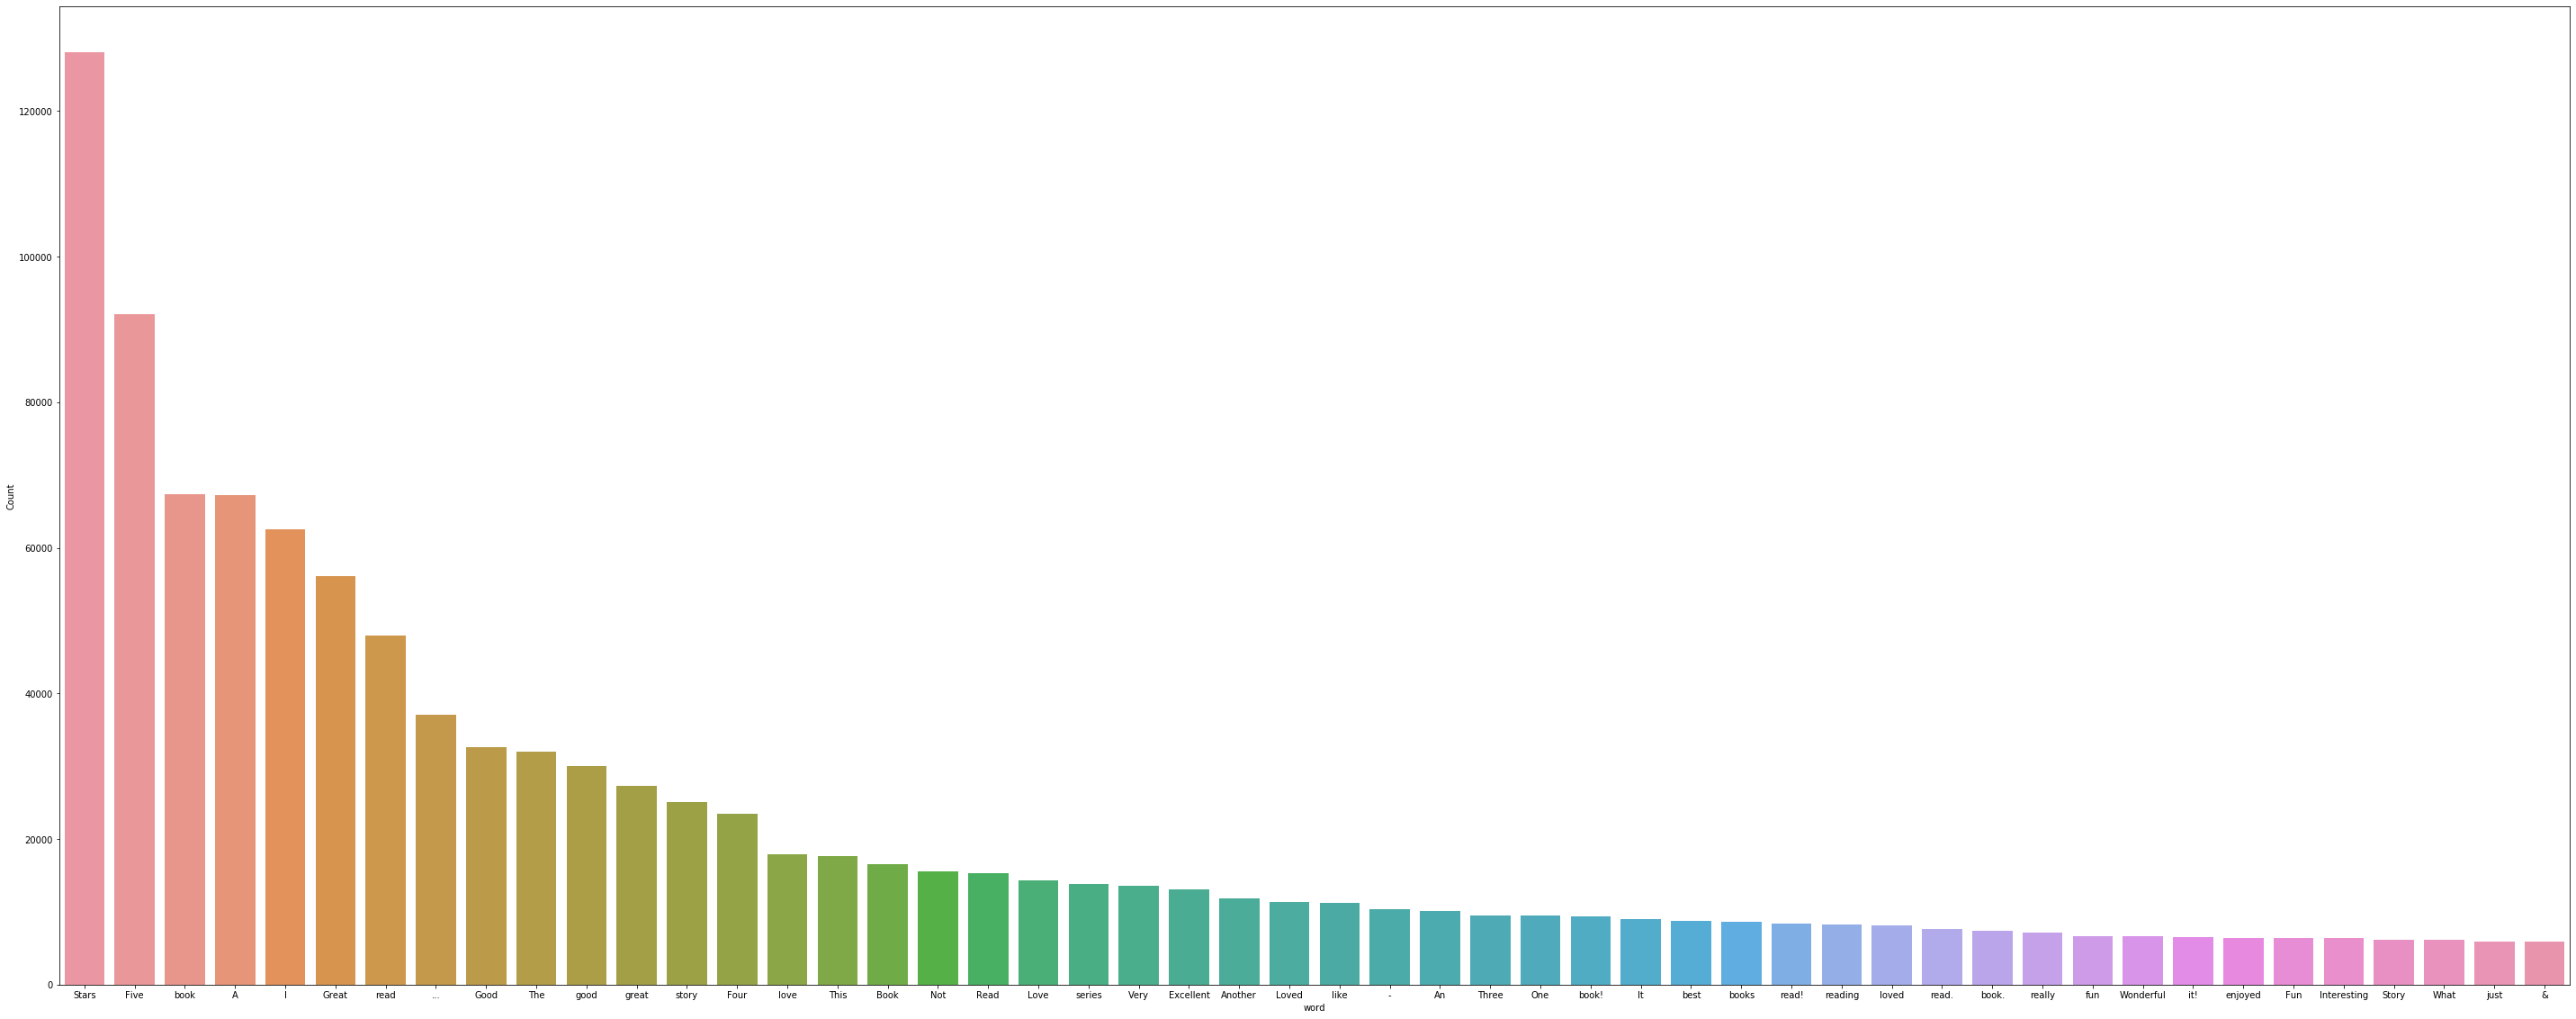

In [ ]:
freq_words(df_obs['summaryWithoutStopwords'])

In [ ]:
Counter(" ".join(df_obs['summaryWithoutStopwords']).split()).most_common(50)

[('Stars', 128023),
 ('Five', 92108),
 ('book', 67340),
 ('A', 67238),
 ('I', 62600),
 ('Great', 56092),
 ('read', 47984),
 ('...', 37092),
 ('Good', 32583),
 ('The', 31972),
 ('good', 29963),
 ('great', 27313),
 ('story', 25082),
 ('Four', 23522),
 ('love', 17915),
 ('This', 17678),
 ('Book', 16485),
 ('Not', 15593),
 ('Read', 15248),
 ('Love', 14264),
 ('series', 13865),
 ('Very', 13542),
 ('Excellent', 13136),
 ('Another', 11790),
 ('Loved', 11375),
 ('like', 11222),
 ('-', 10405),
 ('An', 10114),
 ('Three', 9476),
 ('One', 9464),
 ('book!', 9373),
 ('It', 9000),
 ('best', 8743),
 ('books', 8654),
 ('read!', 8393),
 ('reading', 8269),
 ('loved', 8116),
 ('read.', 7635),
 ('book.', 7435),
 ('really', 7188),
 ('fun', 6627),
 ('Wonderful', 6612),
 ('it!', 6532),
 ('enjoyed', 6462),
 ('Fun', 6372),
 ('Interesting', 6343),
 ('Story', 6135),
 ('What', 6128),
 ('just', 5965),
 ('&', 5955)]

Observation
* From the above graph and tabular data for summary without stopwords it can be observed that 'Stars' has the higest frequency with a count of 128023 and '&' has the lowest frequency with a count of 5955.

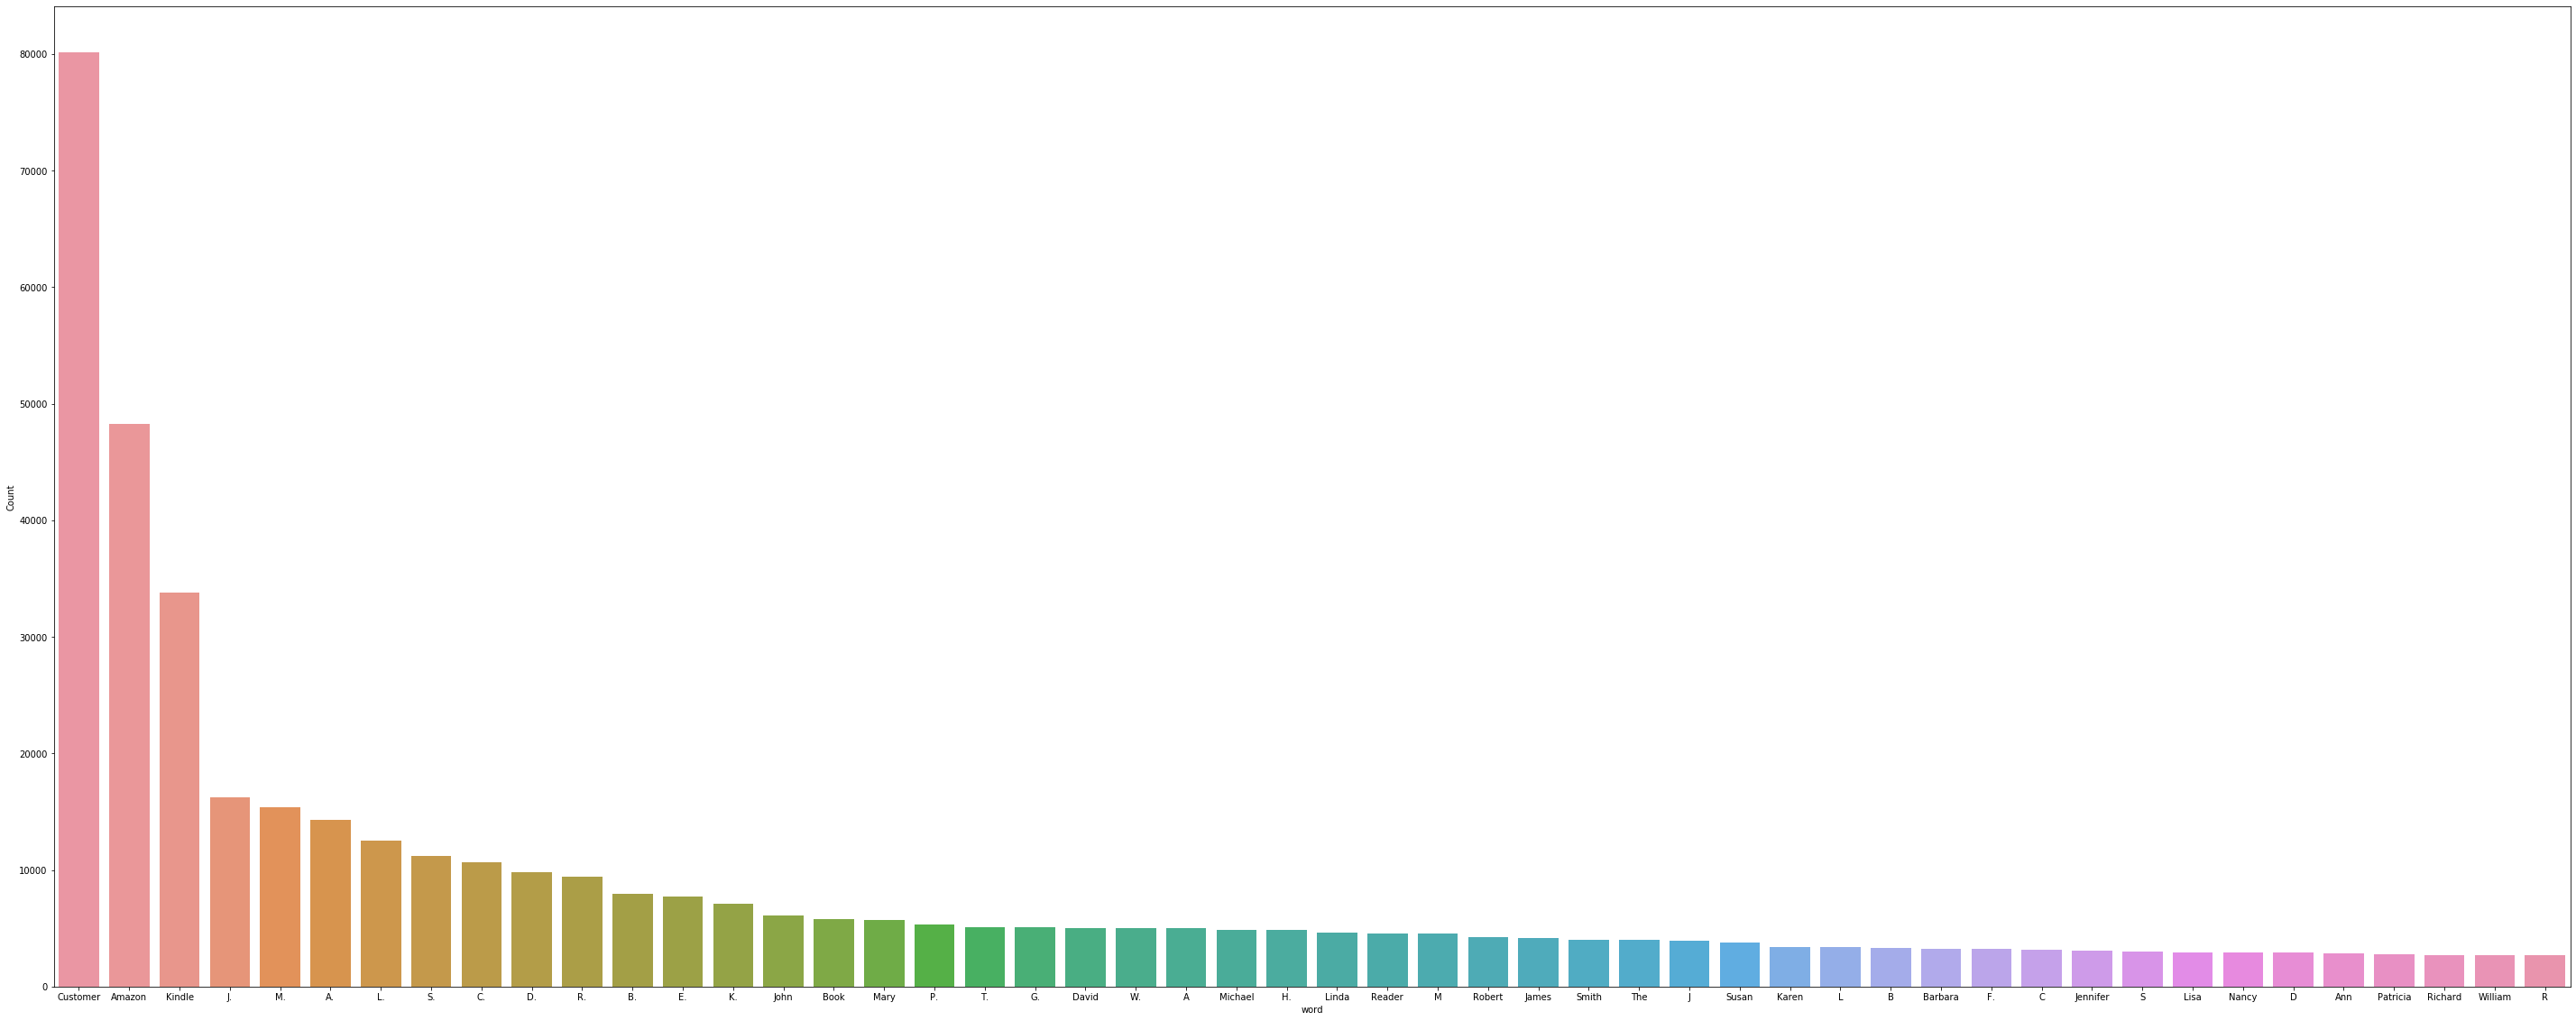

In [ ]:
freq_words(df_obs['reviewerNameWithoutStopwords'])

In [ ]:
Counter(" ".join(df_obs['reviewerNameWithoutStopwords']).split()).most_common(50)

[('Customer', 80114),
 ('Amazon', 48242),
 ('Kindle', 33779),
 ('J.', 16258),
 ('M.', 15379),
 ('A.', 14265),
 ('L.', 12553),
 ('S.', 11188),
 ('C.', 10633),
 ('D.', 9775),
 ('R.', 9390),
 ('B.', 7974),
 ('E.', 7750),
 ('K.', 7098),
 ('John', 6120),
 ('Book', 5788),
 ('Mary', 5705),
 ('P.', 5340),
 ('T.', 5112),
 ('G.', 5061),
 ('David', 5018),
 ('W.', 4989),
 ('A', 4980),
 ('Michael', 4851),
 ('H.', 4842),
 ('Linda', 4612),
 ('Reader', 4574),
 ('M', 4553),
 ('Robert', 4217),
 ('James', 4160),
 ('Smith', 4013),
 ('The', 3971),
 ('J', 3958),
 ('Susan', 3764),
 ('Karen', 3380),
 ('L', 3379),
 ('B', 3297),
 ('Barbara', 3235),
 ('F.', 3215),
 ('C', 3162),
 ('Jennifer', 3046),
 ('S', 3006),
 ('Lisa', 2960),
 ('Nancy', 2952),
 ('D', 2919),
 ('Ann', 2856),
 ('Patricia', 2738),
 ('Richard', 2728),
 ('William', 2699),
 ('R', 2688)]

Observation
* From the above graph and tabular data for reviewerName without stopwords it can be observed that 'Customer' has the higest frequency with a count of 80114 and 'R' has the lowest frequency with a count of 2688.

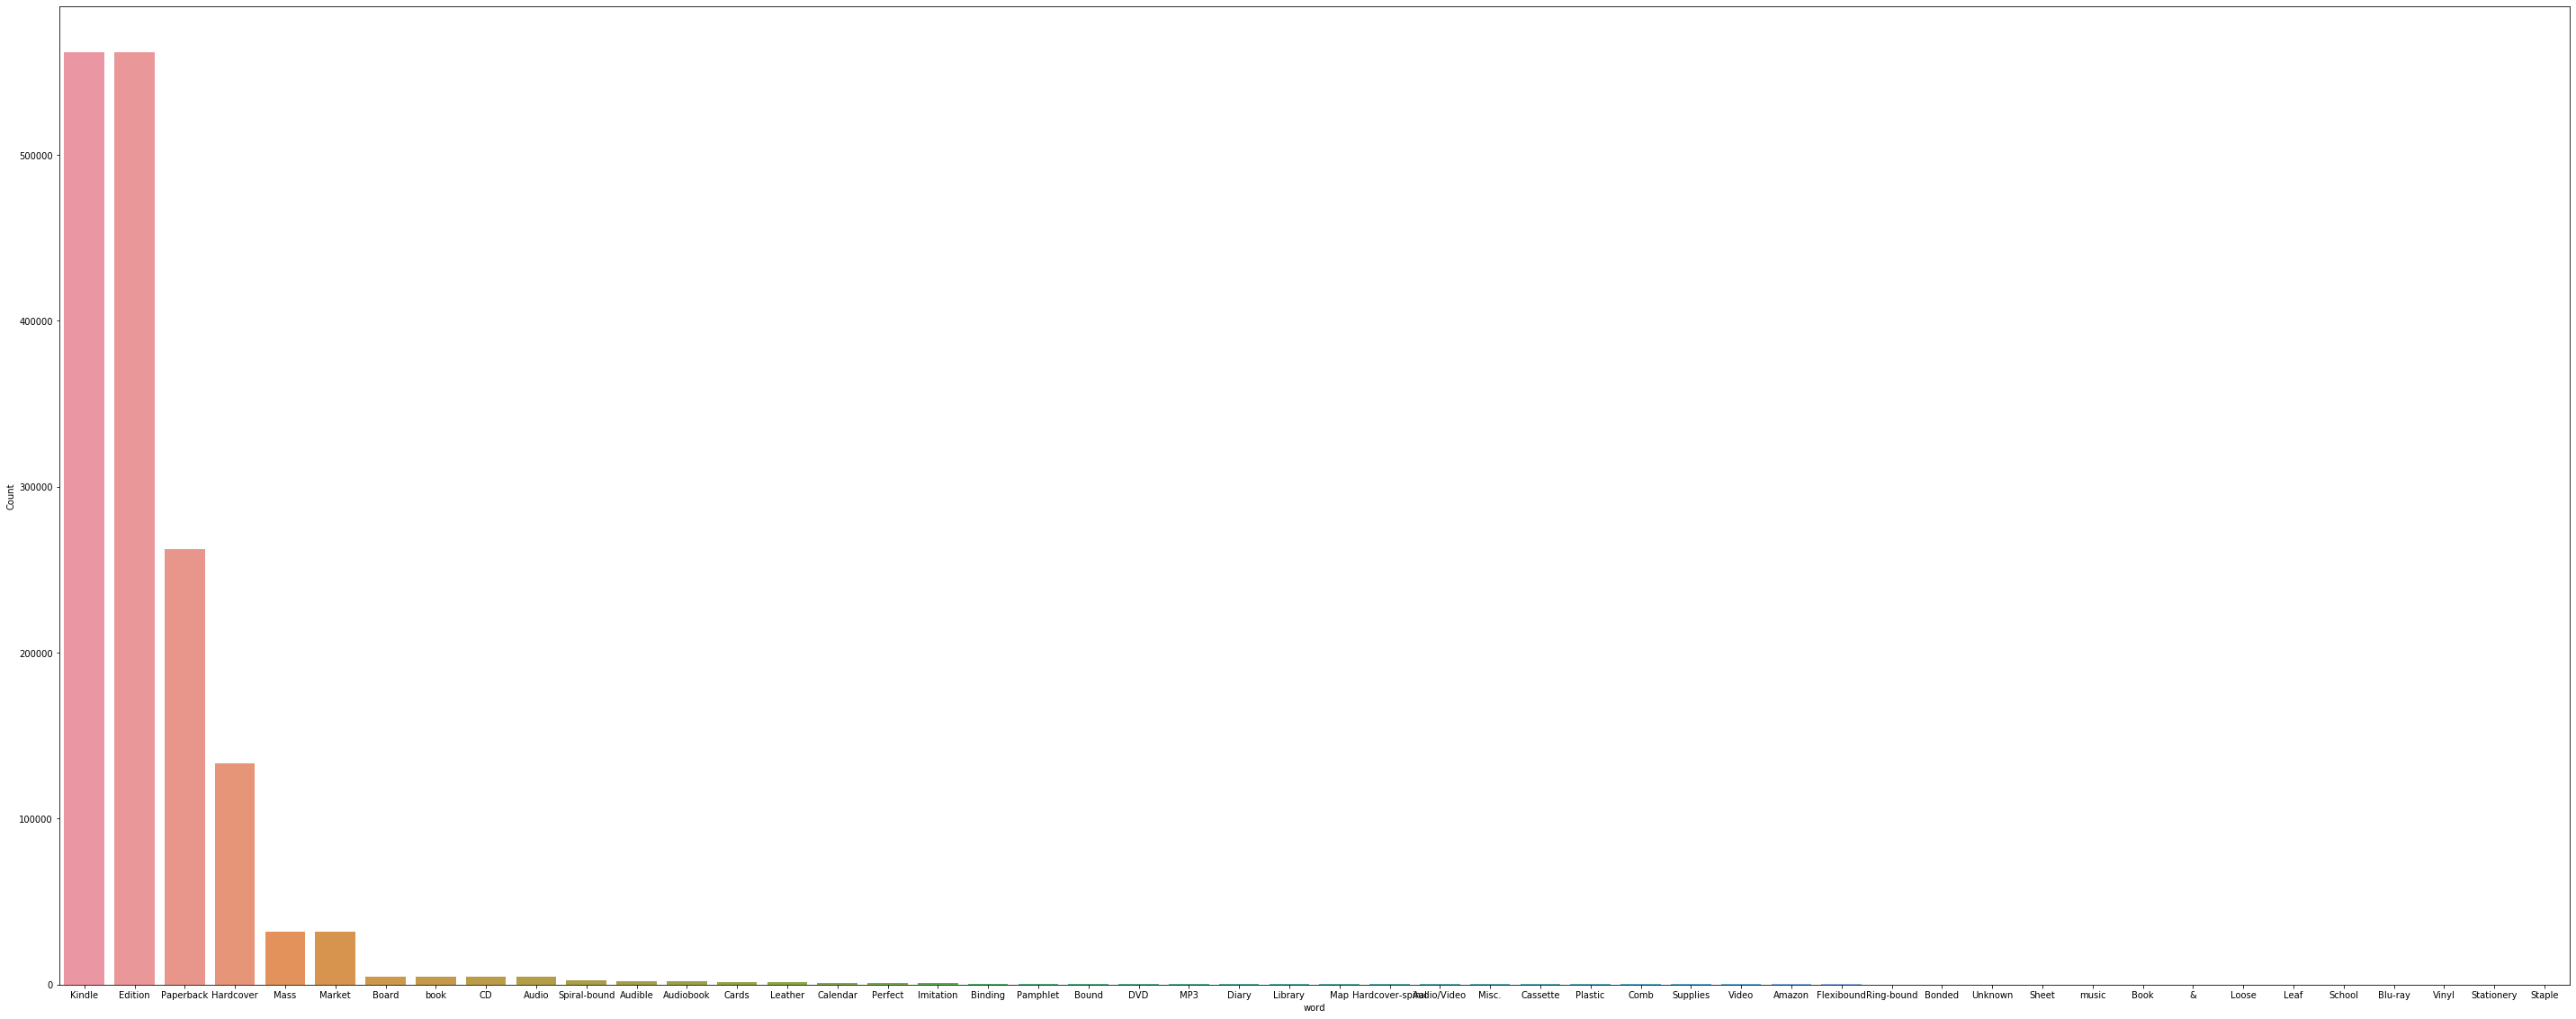

In [ ]:
freq_words(df_obs['formatWithoutStopwords'])

In [ ]:
Counter(" ".join(df_obs['formatWithoutStopwords']).split()).most_common(50)

[('Kindle', 561581),
 ('Edition', 561581),
 ('Paperback', 262166),
 ('Hardcover', 133226),
 ('Mass', 32072),
 ('Market', 32072),
 ('Board', 4846),
 ('book', 4845),
 ('CD', 4792),
 ('Audio', 4676),
 ('Spiral-bound', 2434),
 ('Audible', 2005),
 ('Audiobook', 2005),
 ('Cards', 1642),
 ('Leather', 1430),
 ('Calendar', 905),
 ('Perfect', 853),
 ('Imitation', 813),
 ('Binding', 671),
 ('Pamphlet', 659),
 ('Bound', 619),
 ('DVD', 561),
 ('MP3', 537),
 ('Diary', 518),
 ('Library', 513),
 ('Map', 472),
 ('Hardcover-spiral', 427),
 ('Audio/Video', 423),
 ('Misc.', 409),
 ('Cassette', 391),
 ('Plastic', 382),
 ('Comb', 382),
 ('Supplies', 361),
 ('Video', 359),
 ('Amazon', 326),
 ('Flexibound', 322),
 ('Ring-bound', 157),
 ('Bonded', 155),
 ('Unknown', 135),
 ('Sheet', 105),
 ('music', 105),
 ('Book', 104),
 ('&', 103),
 ('Loose', 102),
 ('Leaf', 102),
 ('School', 101),
 ('Blu-ray', 98),
 ('Vinyl', 90),
 ('Stationery', 88),
 ('Staple', 75)]

Observation
* From the above graph and tabular data for Format without stopwords it can be observed that 'Kindle' has the higest frequency with a count of 561581 and 'Staple' has the lowest frequency with a count of 75.

**2. What is the proportion of each format in the dataset?**

In [ ]:
# Code Reference: https://stackoverflow.com/a/50558594/12146592 [6]
df_obs['format'].value_counts(normalize=True) * 100

 Kindle Edition           57.164017
 Paperback                23.352209
 Hardcover                13.571256
 Mass Market Paperback     3.267109
 Board book                0.493550
                            ...    
 Diskette                  0.000102
 Paperback Bunko           0.000102
 Baby Product              0.000102
 Board Game                0.000102
 Print on Demand           0.000102
Name: format, Length: 89, dtype: float64

Observation
* Kindle Edition has the hightest proportion - 57.16%
* Diskette, Paperback Bunko, Baby Product, Board Game and Print on Demand all have the lowest proportion - 0.000102%

**3. What is the most/least common format of the books?**

Most common format of the books is Kindle Edition, while least common format of the books is DVD Audio

**4. What patterns can you find in your data?**

In [ ]:
df_obs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981663 entries, 0 to 999999
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   overall                       981663 non-null  Int64 
 1   reviewTime                    981663 non-null  string
 2   reviewerID                    981663 non-null  string
 3   asin                          981663 non-null  string
 4   reviewerName                  981663 non-null  string
 5   reviewText                    981663 non-null  string
 6   summary                       981663 non-null  string
 7   unixReviewTime                981663 non-null  Int64 
 8   reviewTextLength              981663 non-null  Int64 
 9   reviewerNameLength            981663 non-null  Int64 
 10  summaryLength                 981663 non-null  Int64 
 11  summaryWord                   981663 non-null  int64 
 12  reviewTextWord                981663 non-null  int64 
 13 

In [ ]:
df_obs['reviewerName'].value_counts()

Amazon Customer     45802
Kindle Customer     31732
Avid Reader           769
Linda                 742
Mary                  733
                    ...  
Golleee                 1
Yellowstone Fan         1
B. Nizza                1
ANsays                  1
Janie C. Watkins        1
Name: reviewerName, Length: 429486, dtype: Int64

From the above observations for reviewer names, it can be inferred that most of the reviewers are anonymous and hence assigned the names as 'Amazon Customer' and 'Kindle Customer', with 'Amazon Customer' having highest reviews.

In [ ]:
df_obs['verified_True'].value_counts(normalize=True) * 100

1    67.464395
0    32.535605
Name: verified_True, dtype: float64

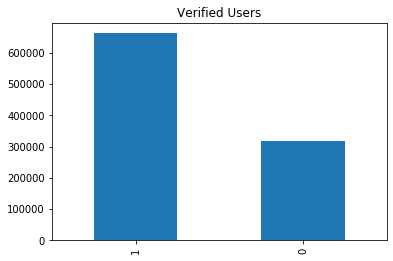

In [ ]:
df_obs['verified_True'].value_counts().plot.bar().set_title('Verified Users');

From the above observations for verified field, it can be seen that 67.46% users are verified, which is significantly higher than the 32.53% of unverified users.

In [ ]:
df_obs['summaryLength'].value_counts()

10     149225
11      40025
9       37880
16      27135
14      27100
        ...  
418         1
432         1
435         1
486         1
500         1
Name: summaryLength, Length: 260, dtype: Int64

The above value distribution for summary lengths shows that in detailed summaries are very low in comparision with one word summaries.

###  2. Text normalization and feature engineering

**1. Create a new column merging review summary and text.**

In [ ]:
df_tn = df
df_tn["review"] = df_tn["summary"] + " " + df_tn["reviewText"]

**2. Remove stop words.**

Removing stop words from the review column created after merging review summray and text.

In [ ]:
# Code Reference: https://stackoverflow.com/a/43407993/12146592 [7]
from sklearn.feature_extraction import text
stop = text.ENGLISH_STOP_WORDS
df_tn['review_without_stopwords'] = df_tn['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_tn.head(5)

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewTextLength,reviewerNameLength,...,summaryIsAlNum_True,verified_False,verified_True,format,reviewTextWithoutStopwords,summaryWithoutStopwords,reviewerNameWithoutStopwords,formatWithoutStopwords,review,review_without_stopwords
0,3,"05 18, 2002",AJ8AQG2X9JJ2Y,0001712799,Donald Gillies,Dr. Seuss has some really brilliant books. Th...,A below-average Dr. Seuss Book,1021680000,617,14,...,0,1,0,School & Library Binding,Dr. Seuss really brilliant books. This book ju...,A below-average Dr. Seuss Book,Donald Gillies,School & Library Binding,A below-average Dr. Seuss Book Dr. Seuss has s...,A below-average Dr. Seuss Book Dr. Seuss reall...
1,5,"12 11, 2014",A12Q7B7NT716RV,0001712799,True Value Girl,Love it,Five Stars,1418256000,7,15,...,0,0,1,Hardcover,Love,Five Stars,True Value Girl,Hardcover,Five Stars Love it,Five Stars Love
2,4,"01 6, 2006",A1DK5AZMXS1QA3,0002006448,Newton Ooi,Hand-woven carpets are one of the few products...,Tourism as history,1136505600,1419,10,...,0,1,0,Hardcover,Hand-woven carpets products Central Asia consi...,Tourism history,Newton Ooi,Hardcover,Tourism as history Hand-woven carpets are one ...,Tourism history Hand-woven carpets products Ce...
3,4,"12 8, 2014",A1JMSX54DO3LOP,0002005263,Bookzilla,"Compelling, twisting mystery involving several...","Compelling, twisting mystery",1417996800,314,9,...,0,1,0,Kindle Edition,"Compelling, twisting mystery involving law ent...","Compelling, twisting mystery",Bookzilla,Kindle Edition,"Compelling, twisting mystery Compelling, twist...","Compelling, twisting mystery Compelling, twist..."
4,2,"03 3, 2014",A2IP27AZB3D1SM,0002005263,J. A. Drummond,I have read many of the Hillerman books and en...,Tony missed the mark,1393804800,235,14,...,0,0,1,Kindle Edition,I read Hillerman books enjoyed immensely. The ...,Tony missed mark,J. A. Drummond,Kindle Edition,Tony missed the mark I have read many of the H...,Tony missed mark I read Hillerman books enjoye...


**3. Remove numbers and other non-letter characters**

Removing numbers and special characters from the review column.

In [ ]:
df_tn['review_without_stopwords'] = df_tn['review_without_stopwords'].replace('[^a-zA-Z ]', '', regex=True)

**4. Perform either lemmatization or stemming. Motivate your choice.**

We have performed **lemmatization** on the processed reviews. We have selected lemmatization because it considers the context of the words during determining words with same root and mapping them, while stemming just simply strips the suffixes from the end of the word <a href='https://dal.brightspace.com/d2l/le/content/221741/viewContent/3070214/View'>[8]</a>. 

Some resources:
https://stackoverflow.com/a/71264583/12146592
https://www.kaggle.com/code/thrillanalysis/amazon-reviews-analysis/notebook
https://github.com/girishkuniyal/Sentiment-Analysis---Amazon-review-dataset


In [ ]:
!pip install nltk

import nltk
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package wordnet to
[nltk_data]     /users/grad/meghnak/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Code Reference: https://github.com/girishkuniyal/Sentiment-Analysis---Amazon-review-dataset/tree/master/4.BOW_lemmatization [9]
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /users/grad/meghnak/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
nltk.download('punkt')
def tokenize_lemmatize(review_data):
  X_data = []
  for i in range(review_data.shape[0]):
      token = word_tokenize(review_data.review_without_stopwords.iloc[i])
      for i in range(len(token)):
          token[i] = lemmatizer.lemmatize(token[i])
      token = ' '.join(token)
      X_data.append(token)
  return X_data
 
df_tn['lemmatized_review'] = pd.DataFrame(tokenize_lemmatize(df_tn))

[nltk_data] Downloading package punkt to
[nltk_data]     /users/grad/meghnak/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df_tn.head(5)

,overall,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,reviewTextLength,reviewerNameLength,...,verified_False,verified_True,format,reviewTextWithoutStopwords,summaryWithoutStopwords,reviewerNameWithoutStopwords,formatWithoutStopwords,review,review_without_stopwords,lemmatized_review
0,3,"05 18, 2002",AJ8AQG2X9JJ2Y,0001712799,Donald Gillies,Dr. Seuss has some really brilliant books. Th...,A below-average Dr. Seuss Book,1021680000,617,14,...,1,0,School & Library Binding,Dr. Seuss really brilliant books. This book ju...,A below-average Dr. Seuss Book,Donald Gillies,School & Library Binding,A below-average Dr. Seuss Book Dr. Seuss has s...,A belowaverage Dr Seuss Book Dr Seuss really b...,A belowaverage Dr Seuss Book Dr Seuss really b...
1,5,"12 11, 2014",A12Q7B7NT716RV,0001712799,True Value Girl,Love it,Five Stars,1418256000,7,15,...,0,1,Hardcover,Love,Five Stars,True Value Girl,Hardcover,Five Stars Love it,Five Stars Love,Five Stars Love
2,4,"01 6, 2006",A1DK5AZMXS1QA3,0002006448,Newton Ooi,Hand-woven carpets are one of the few products...,Tourism as history,1136505600,1419,10,...,1,0,Hardcover,Hand-woven carpets products Central Asia consi...,Tourism history,Newton Ooi,Hardcover,Tourism as history Hand-woven carpets are one ...,Tourism history Handwoven carpets products Cen...,Tourism history Handwoven carpet product Centr...
3,4,"12 8, 2014",A1JMSX54DO3LOP,0002005263,Bookzilla,"Compelling, twisting mystery involving several...","Compelling, twisting mystery",1417996800,314,9,...,1,0,Kindle Edition,"Compelling, twisting mystery involving law ent...","Compelling, twisting mystery",Bookzilla,Kindle Edition,"Compelling, twisting mystery Compelling, twist...",Compelling twisting mystery Compelling twistin...,Compelling twisting mystery Compelling twistin...
4,2,"03 3, 2014",A2IP27AZB3D1SM,0002005263,J. A. Drummond,I have read many of the Hillerman books and en...,Tony missed the mark,1393804800,235,14,...,0,1,Kindle Edition,I read Hillerman books enjoyed immensely. The ...,Tony missed mark,J. A. Drummond,Kindle Edition,Tony missed the mark I have read many of the H...,Tony missed mark I read Hillerman books enjoye...,Tony missed mark I read Hillerman book enjoyed...


**5.  Convert the corpus into a bag-of-words TF-IDF weighted vector representation.**

In [ ]:
df_tn = df_tn.dropna()

In the bag-of-words a text is represented as the bag (multiset) of its words, disregarding grammar and even word order but keeping multiplicity <a href='https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22'>[10]</a>.

In [ ]:
# Code Reference: https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22 [10]
from sklearn.feature_extraction.text import CountVectorizer
vectorize = CountVectorizer()
text_bow = vectorize.fit_transform(df_tn['lemmatized_review'])


TFIDF (term frequency-inverse document frequency), is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general <a href='https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22'>[10]</a>.

In [ ]:
# Code Reference: https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22 [10]
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
text_tfidf = vectorizer.fit_transform(df_tn['lemmatized_review'])

In [ ]:
print(text_bow.shape)

(964504, 566361)


In [ ]:
print(text_tfidf.shape)

(964504, 566361)


### 3. Build a model to predict overall score

**1. Use score as the target variable. Explain what is the task you’re solving**

The task that is being solved is Supervised Classification because the target feature that needs to be predicted - 'score' is a feature is a discrete value which only has five possible values ranging from 0 to 5 and supervised classification is used to predict/classify discrete values.

**2. Use a feature selection method to select the features to build a model.**

In [ ]:
df_test = df_tn

In [ ]:
df_test = df_test.dropna()

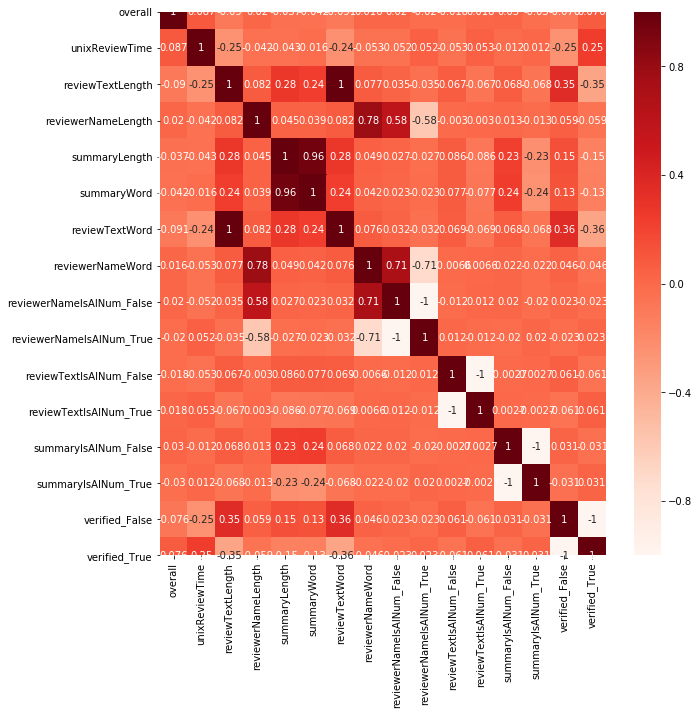

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df_test.corr(),annot=True, cmap=plt.cm.Reds)

From the above correlation heatmap of the dataset it can be observed that -
* 'overall score' has a positive correlation with most of the values
* 'overall score has a negative correlation with summaryIsAlNum_True, reviewerNameIAlNum_True, and reviewTextLength

Features selected on following assumptions
* Our target feature is 'overall' which indicates the score
* Since it is the score of the review the most important feature would be the provided review.
* In the above section a single column has been created using reviewText and summary which has all the stopwords removed and has been further lemmatized.
* Our other feature would be lemmatized_review
* Rest of the features like verified, format or reviewerName are not going to help in predicting overall score hence the can be left.

In [ ]:
y = df_test['overall']
X= df_test['lemmatized_review']

Splitting the dataset into test train with a ratio of 80 and 20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                   random_state=23)

**3. Select the evaluation metric/metrics. Justify your choice.**

We have selected Confusion Matrix as the evaluation metric as the model that is being built is a classification model and to evaluate the performance of the model we need a metric that evaluates the precision of the predicted values with the actual values. We'll use the components of the confusion matrix to evaluate the model <a href='https://dal.brightspace.com/d2l/lms/dropbox/user/folders_history.d2l?db=151136&grpid=227532&isprv=0&bp=0&ou=221741'>[11]</a>.

A confusion matrix is a n x n matrix (where n is the number of labels) used to describe the performance of a classification model. Each row in the confusion matrix represents an actual class whereas each column represents a predicted class. <a href='https://www.analyticsvidhya.com/blog/2021/12/evaluation-of-classification-model/'>[12]</a>

* Precision - How many are actually true from all the predicted outputs
* Recall - How many were retrieved by the model from all the actual Positive cases
* F1 score - F1 score is a hybrid of precision and recall, which provides the Harmonic mean of Precision and Recall

**4. Perform hyperparameter tuning if applicable.**

Model can be trained without hyperparameter tuning.

**5. Train and evaluate your model.**

In [ ]:
y_train=y_train.astype('int')

In [ ]:
# Code Reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html [13]
# Code Reference: https://dal.brightspace.com/d2l/le/content/221741/viewContent/3070214/View [8]
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
clf=Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])
clf_trained = clf.fit(X_train, y_train)

In [ ]:
y_train_pred=clf_trained.predict(X_train)

In [ ]:
y_pred=clf_trained.predict(X_test)

In [ ]:
print(confusion_matrix(y_train,y_train_pred))
print(classification_report(y_train,y_train_pred))

[[     2      0      1     12  23424]
 [     0      6      1     15  28750]
 [     0      0     31     20  68052]
 [     0      2      6    583 167328]
 [     2     11     46     80 483231]]
              precision    recall  f1-score   support

           1       0.50      0.00      0.00     23439
           2       0.32      0.00      0.00     28772
           3       0.36      0.00      0.00     68103
           4       0.82      0.00      0.01    167919
           5       0.63      1.00      0.77    483370

    accuracy                           0.63    771603
   macro avg       0.53      0.20      0.16    771603
weighted avg       0.63      0.63      0.48    771603



In [ ]:
y_test=y_test.astype('int')

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[     0      0      0      1   5917]
 [     0      0      0      0   7263]
 [     0      0      0      3  16984]
 [     0      0      2      7  42143]
 [     0      1      0     18 120562]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5918
           2       0.00      0.00      0.00      7263
           3       0.00      0.00      0.00     16987
           4       0.24      0.00      0.00     42152
           5       0.63      1.00      0.77    120581

    accuracy                           0.63    192901
   macro avg       0.17      0.20      0.15    192901
weighted avg       0.44      0.63      0.48    192901



**6. How do you make sure not to overfit?**

> Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data <a href='https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms'>[14]</a>. 

> For our scenario, the accuracy of model on training is 63% and on test data it is 63%. Since the difference between the accuracy of the model is same, it can be concluded that the model is not overfitting.

> In general, to avoid overfitting of a model, a hyperparameter tuning can be performed on the model or less/more number of features can be used <a href='https://dal.brightspace.com/d2l/lms/dropbox/user/folders_history.d2l?db=151136&grpid=227532&isprv=0&bp=0&ou=221741'>[11]</a>.

**7. Plot a visualization of the learning process or the learned information of the
model**

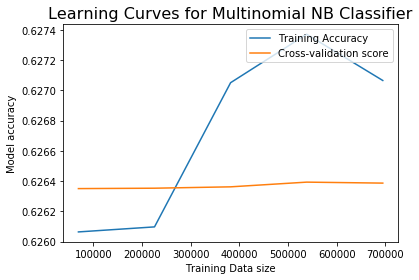

In [ ]:
plt.title("Learning Curves for Multinomial NB Classifier", fontsize=16)
train_sizes, train_score, test_score, fit_times, _ = learning_curve(clf_trained, X_train, y_train,cv=10, return_times=True)
plt.xlabel("Training Data size")
plt.ylabel("Model accuracy")
plt.plot(train_sizes,np.mean(train_score,axis=1), label = 'Training Accuracy')
plt.plot(train_sizes, np.mean(test_score, axis=1),label = 'Cross-validation score')
plt.legend(loc='upper right')

> A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error <a href='https://stackoverflow.com/a/67014482'>[15]</a>.

> From the Learning Curve graph for MultinomialNB Classifier above, it can be observed that the curves for the Training Accuracy and Cross-Validation are intersecting at about approximately 260000 values. The cross validation score is consistent across the training dataset while there is a sudden increase in the Training Accuracy of the model post ~220000 training data size.

**Analyze the results.**

> Train results for MultinomialNB Classifier:

* The precision result is highest for target value 4 - 0.82 while lowest for  2 target value 0.32
* The recall results are observed to be 1.00 for 5 target value while for all others it is 0.0
* The accuracy for the train dataset is 63%.

> Test results for MultinomialNB Classifier:

* The precision results for 4 and 5 target value are 0.24 and 0.63 respectively while for all others it is 0.0.
* The recall results are observed to be 1.00 for 5 target value while for all others it is 0.0
* The accuracy for the test dataset is 63%.

> From the accuracy scores for both datasets train and test, it can be concluded that the model has a decent and consistent performance.

### 4. Perform part-of-speech tagging

**1. Perform part-of-speech tagging on the raw data (i.e. prior to Q2), and/or after
processing (after Q2), and extract the nouns only to obtain a bag-of-words tf-idf
weighted vector. representation using only the nouns.**

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag, pos_tag_sents

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /users/grad/meghnak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Performing part-of-speech tagging on data after processing (after Q2), i.e., lemmatized review.

In [ ]:
# Code Reference: https://stackoverflow.com/a/42081746 [16]
df_tn['review_pos'] = pos_tag_sents(df_tn['lemmatized_review'].apply(word_tokenize).tolist())

/local/pkg/python/root-python-3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



* Storing the target and feature variables.
* Further processing the review_pos feature for only extracting the noun words.
* The words that have tag values starting from N are noun values

In [ ]:
y_pos = df_tn['overall']
X_pos= df_tn['review_pos']
# Code Reference: https://stackoverflow.com/a/24410428 [17]
X_pos = [" ".join([word for word, tag in sent if tag.startswith('N')]) for sent in X_pos]

In [ ]:
X_pos = pd.Series(X_pos)

In [ ]:
X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, 
                                                    test_size=0.2,
                                                   random_state=23)

In [ ]:
y_pos_train=y_pos_train.astype('int')

In [ ]:
# Code Reference: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html [13]
# Code Reference: https://dal.brightspace.com/d2l/le/content/221741/viewContent/3070214/View [8]
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
clf_pos=Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('classifier', MultinomialNB()),
])
clf_pos_trained = clf_pos.fit(X_pos_train, y_pos_train)

In [ ]:
y_pos_train_pred=clf_pos_trained.predict(X_pos_train)

In [ ]:
y_pos_pred=clf_pos_trained.predict(X_pos_test)

In [ ]:
print(confusion_matrix(y_pos_train,y_pos_train_pred))
print(classification_report(y_pos_train,y_pos_train_pred))

[[     4      0      0     20  23415]
 [     0      8      1     22  28741]
 [     0      0     39     37  68027]
 [     0      2      2   1164 166751]
 [     2      5     38     68 483257]]
              precision    recall  f1-score   support

           1       0.67      0.00      0.00     23439
           2       0.53      0.00      0.00     28772
           3       0.49      0.00      0.00     68103
           4       0.89      0.01      0.01    167919
           5       0.63      1.00      0.77    483370

    accuracy                           0.63    771603
   macro avg       0.64      0.20      0.16    771603
weighted avg       0.67      0.63      0.49    771603



In [ ]:
y_pos_test=y_pos_test.astype('int')

In [ ]:
print(confusion_matrix(y_pos_test,y_pos_pred))
print(classification_report(y_pos_test,y_pos_pred))

[[     0      0      0      0   5918]
 [     0      0      0      1   7262]
 [     0      0      0      7  16980]
 [     0      0      0     14  42138]
 [     0      0      1     26 120554]]
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5918
           2       0.00      0.00      0.00      7263
           3       0.00      0.00      0.00     16987
           4       0.29      0.00      0.00     42152
           5       0.63      1.00      0.77    120581

    accuracy                           0.63    192901
   macro avg       0.18      0.20      0.15    192901
weighted avg       0.45      0.63      0.48    192901



Plot a visualization of the learning process or the learned information of the
model

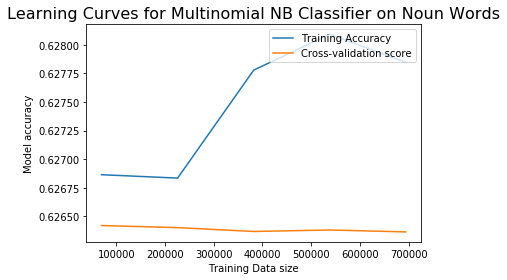

In [ ]:
plt.title("Learning Curves for Multinomial NB Classifier on Noun Words", fontsize=16)
train_sizes, train_score, test_score, fit_times, _ = learning_curve(clf_pos_trained, X_pos_train, y_pos_train,cv=10, return_times=True)
plt.xlabel("Training Data size")
plt.ylabel("Model accuracy")
plt.plot(train_sizes,np.mean(train_score,axis=1), label = 'Training Accuracy')
plt.plot(train_sizes, np.mean(test_score, axis=1),label = 'Cross-validation score')
plt.legend(loc='upper right')

> From the Learning Curve graph for MultinomialNB Classifier above trained on the dataset after pos tagging and considering only noun words, it can be observed that the curves for the Training Accuracy and Cross-Validation are completely apart from each other. The cross validation score is low and consistent across the training dataset with a value less than 0.62 while Training accuracy has risen massively after ~220000 training data from ~0.627 to ~0.628.

**Analyze the Results**

> Train results for MultinomialNB Classifier on Noun words:

* The precision result is highest for target value 4 - 0.89 while lowest for  3 target value 0.49
* The recall results are observed to be 1.00 and 0.01 for 5 and 4 target value while for all others it is 0.0
* The accuracy for the train dataset is 63%.

> Test results for MultinomialNB Classifier on Noun words:

* The precision results for 4 and 5 target value are 0.29 and 0.63 respectively while for all others it is 0.0.
* The recall results are observed to be 1.00 for 5 target value while for all others it is 0.0
* The accuracy for the test dataset is 63%.

> From the accuracy scores for both datasets train and test, it can be concluded that the model has a decent and consistent performance.

**3. Compare the performance with what you received in Q3 and Q4 with a statistical
significance test. Discuss your findings.**

In [ ]:
%pip install mlxtend

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import mlxtend

In [ ]:
# Code Reference: http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_resampled/ [18]
from mlxtend.evaluate import paired_ttest_resampled
t,p = paired_ttest_resampled(estimator1=clf_trained,estimator2=clf_pos_trained, X=X_test, y=y_test, random_seed = 1)
print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: nan
p value: nan


/users/grad/meghnak/.local/lib/python3.7/site-packages/mlxtend/evaluate/ttest.py:126: RuntimeWarning: invalid value encountered in double_scalars
  t_stat = numerator / denominator


Calculating the cross validate score for the models that are trained on different datasets <a href='https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python#mcetoc_1g1oehhmkb'>[19]</a>

In [ ]:
from sklearn import model_selection
results = []
kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(clf_trained, X_train, y_train, cv=kfold, scoring='accuracy')
results.append(cv_results)
cv_results_pos = model_selection.cross_val_score(clf_pos_trained, X_pos_train, y_pos_train, cv=kfold, scoring='accuracy')
results.append(cv_results_pos)

In [ ]:
print(np.median(results[0]))
print(np.median(results[1]))

0.625795414782079
0.6258148546545534


> Observation

* After calculating the cross_val_score for both the models it is observed that the median score value for model trained with all the review data is less than that of median score value for model trained with data after pos tagging and considering only nouns.

* The median cross_val_score for clf_trained model is 0.625795
* The median cross_val_score for cls_pos_trained model is 0.625814


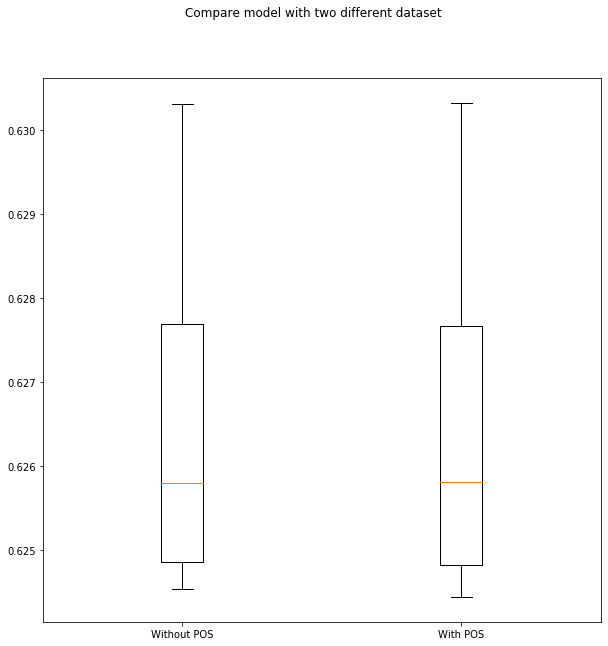

In [ ]:
fig = plt.figure(figsize=(10,10))
fig.suptitle('Compare model with two different dataset')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(['Without POS','With POS'])
plt.show()

> Observation
> * From the boxplot for the both the models above it can be seen that the median for model with POS is slighly higher than that of without POS.

### References

[1] Kaggle.com. 2022. Amazon Book Review 1 Million Sample. [online] Available at: <https://www.kaggle.com/datasets/parvezmrobin/amazon-book-review-1m-sample> [Accessed 24 July 2022].

[2] Maksym Taranukhin, “CSCI 4146/6409 Process of Data Science Tutorial 2.” Summer Term, Dalhousie University, [online document], 2022. [Accessed 22 July 2022]

[3] P. and Foley, L., 2022. Python remove stop words from pandas dataframe. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/43407993/12146592> [Accessed 24 July 2022].

[4] Kaggle.com. 2022. Amazon reviews analysis. [online] Available at: <https://www.kaggle.com/code/thrillanalysis/amazon-reviews-analysis/notebook> [Accessed 24 July 2022].

[5] C., saoji, s., Beasley, J. and Pardhan, A., 2022. Count most frequent 100 words from sentences in Dataframe Pandas. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/29903102/12146592> [Accessed 24 July 2022].

[6] P. and Gunda, R., 2022. Pandas get frequency of item occurrences in a column as percentage. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/50558594/12146592> [Accessed 24 July 2022].

[7] P. and Foley, L., 2022. Python remove stop words from pandas dataframe. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/43407993/12146592> [Accessed 24 July 2022].

[8] Maksym Taranukhin, “CSCI 4146/6409 Process of Data Science Tutorial 11.” Summer Term, Dalhousie University, [online document], 2022. [Accessed 22 July 2022]

[9] GitHub. 2022. Sentiment-Analysis---Amazon-review-dataset/4.BOW_lemmatization at master · girishkuniyal/Sentiment-Analysis---Amazon-review-dataset. [online] Available at: <https://github.com/girishkuniyal/Sentiment-Analysis---Amazon-review-dataset/tree/master/4.BOW_lemmatization> [Accessed 24 July 2022].

[10] Medium. 2022. Fundamentals of Bag Of Words and TF-IDF. [online] Available at: <https://medium.com/analytics-vidhya/fundamentals-of-bag-of-words-and-tf-idf-9846d301ff22> [Accessed 24 July 2022].

[11] Meghna Kumar and Vatsal Yadav, “CSCI 4146/6409 Process of Data Science Assignment 2.” Summer Term, Dalhousie University, [online document], 2022. [Accessed 22 July 2022]

[12] Analytics Vidhya. 2022. Evaluation of Classification Model - Analytics Vidhya. [online] Available at: <https://www.analyticsvidhya.com/blog/2021/12/evaluation-of-classification-model/> [Accessed 24 July 2022].

[13] scikit-learn. 2022. sklearn.naive_bayes.MultinomialNB. [online] Available at: <https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html> [Accessed 24 July 2022].

[14] Brownlee, J., 2022. Overfitting and Underfitting With Machine Learning Algorithms. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms> [Accessed 24 July 2022].

[15] W. and Jones, H., 2022. What does the learning curve in classification decision tree mean?. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/67014482> [Accessed 24 July 2022].

[16] H. and Curt, I., 2022. How to apply pos_tag_sents() to pandas dataframe efficiently. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/42081746> [Accessed 24 July 2022].

[17] H., Kramer, C. and Rahman, H., 2022. How to extract nouns using NLTK pos_tag()?. [online] Stack Overflow. Available at: <https://stackoverflow.com/a/24410428> [Accessed 24 July 2022].

[18] Raschka, S., 2022. paired_ttest_resample: Resampled paired *t* test - mlxtend. [online] Rasbt.github.io. Available at: <http://rasbt.github.io/mlxtend/user_guide/evaluate/paired_ttest_resampled/> [Accessed 24 July 2022].

[19] ProjectPro. 2022. How to compare sklearn classification algorithms in Python? -. [online] Available at: <https://www.projectpro.io/recipes/compare-sklearn-classification-algorithms-in-python#mcetoc_1g1oehhmkb> [Accessed 24 July 2022].